HRV Time-Domain Metrics:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  969.132167  138.35349   58.661954  105.779172   48.173937  112.515063   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   37.141412  122.515169  113.658467  113.673605  ...      120.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.217274        910.0       1049.0  54.724092  82.799462      101.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1425.0  10.150273       0.0  

[1 rows x 25 columns]

HRV Frequency-Domain Metrics:
    HRV_ULF   HRV_VLF    HRV_LF    HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  \
0  0.000667  0.008424  0.006423  0.005556  0.000869  0.021939  1.156055   

    HRV_LFn   HRV_HFn  HRV_LnHF  
0  0.292769  0.253248 -5.192895  

HRV Non-Linear Metrics:
     HRV_SD1     HRV_SD2  HRV_SD1SD2         HRV_S   HRV_CSI   HRV_CVI  \
0  80.379377  178.073395    0.451383  44966.962145  2.215411  5.359864   

   HRV_CS

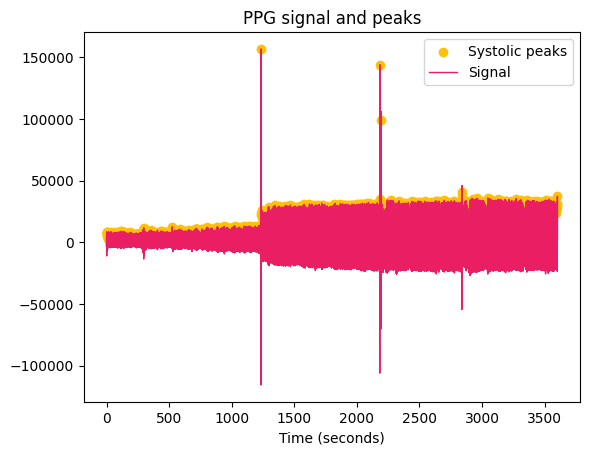

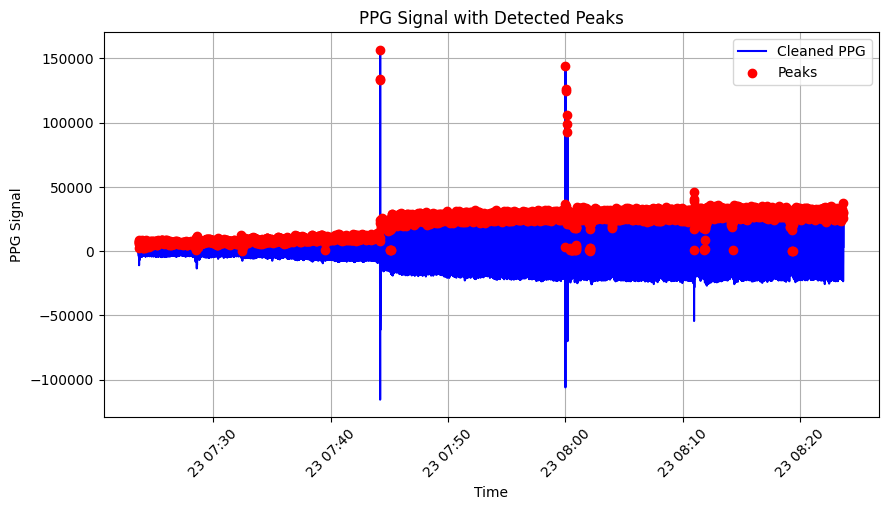

In [4]:
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import json

# 기존 Firebase 앱이 있으면 삭제하고 새로 초기화
if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# Firebase 앱 초기화 (사용자의 키와 URL로 수정 필요)
cred = credentials.Certificate("hrvdataset-firebase-adminsdk-oof96-2a96d6ac7f.json")  # Firebase Admin SDK JSON 파일
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

# 데이터 가져오기
# ref = db.reference("HeartRateData")
# data = ref.get()

# wakeup.json 파일에서 데이터 불러오기
with open("gosleep.json", "r") as f:
    data_json = json.load(f)


# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data_json["HeartRateData"].items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성 및 정렬
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")

# 초반 2초 데이터 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 청소 (샘플링 주파수 25Hz)
fs = 25
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# 피크 검출 함수 (min_y 추가)
def find_prominent_peaks(signal, threshold=0.1, min_y=0):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > min_y:
            left_min = min(signal[max(0, i - 5):i])
            right_min = min(signal[i + 1:i + 6])
            prominence = signal[i] - max(left_min, right_min)
            if prominence > threshold:
                peaks.append(i)
    return peaks

# 피크 검출
min_y = 0
peaks_indices = find_prominent_peaks(ppg_cleaned, threshold=0.1, min_y=min_y)


# 피크의 타임스탬프와 값 추출
peaks_timestamps = df["Timestamp"].iloc[peaks_indices].values
peaks_values = ppg_cleaned[peaks_indices]

# RR 간격 계산 (밀리초 단위)
rr_intervals = np.diff(peaks_timestamps).astype('timedelta64[ms]').astype(int)

# RR 간격을 다시 피크 인덱스로 변환
peaks_from_rr = nk.intervals_to_peaks(rr_intervals)

# PPG 피크 검출
peaks, info = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs, show=True)

# peaks 데이터프레임의 인덱스를 df와 일치시키기
peaks["Timestamp"] = df["Timestamp"].reset_index(drop=True)

# HRV 도메인별 분석
hrv_time_metrics = nk.hrv_time(peaks_from_rr, sampling_rate=1000)
hrv_frequency_metrics = nk.hrv_frequency(peaks_from_rr, sampling_rate=1000)
hrv_nonlinear_metrics = nk.hrv_nonlinear(peaks_from_rr, sampling_rate=1000)

# HRV 지표 출력
print("HRV Time-Domain Metrics:")
print(hrv_time_metrics)
print("\nHRV Frequency-Domain Metrics:")
print(hrv_frequency_metrics)
print("\nHRV Non-Linear Metrics:")
print(hrv_nonlinear_metrics)


# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks_timestamps, peaks_values, color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()


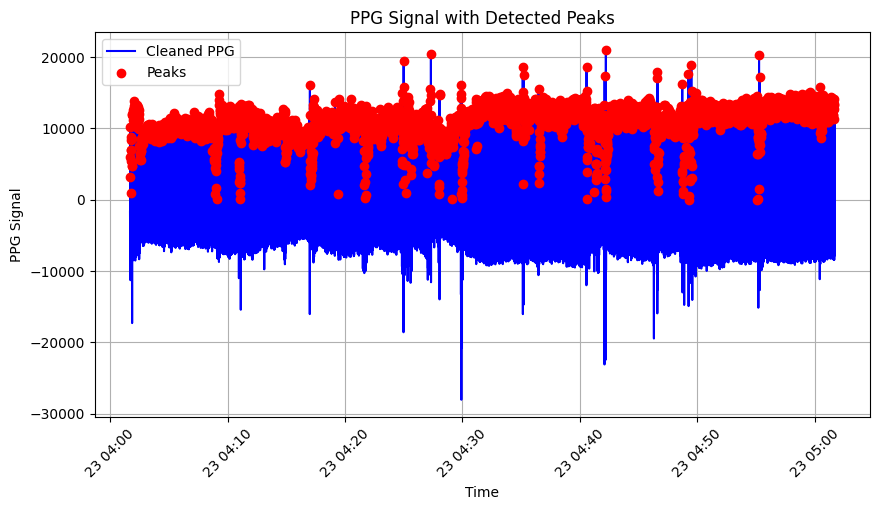

/home/pjy008008/.local/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/pjy008008/.local/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/pjy008008/.local/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windo

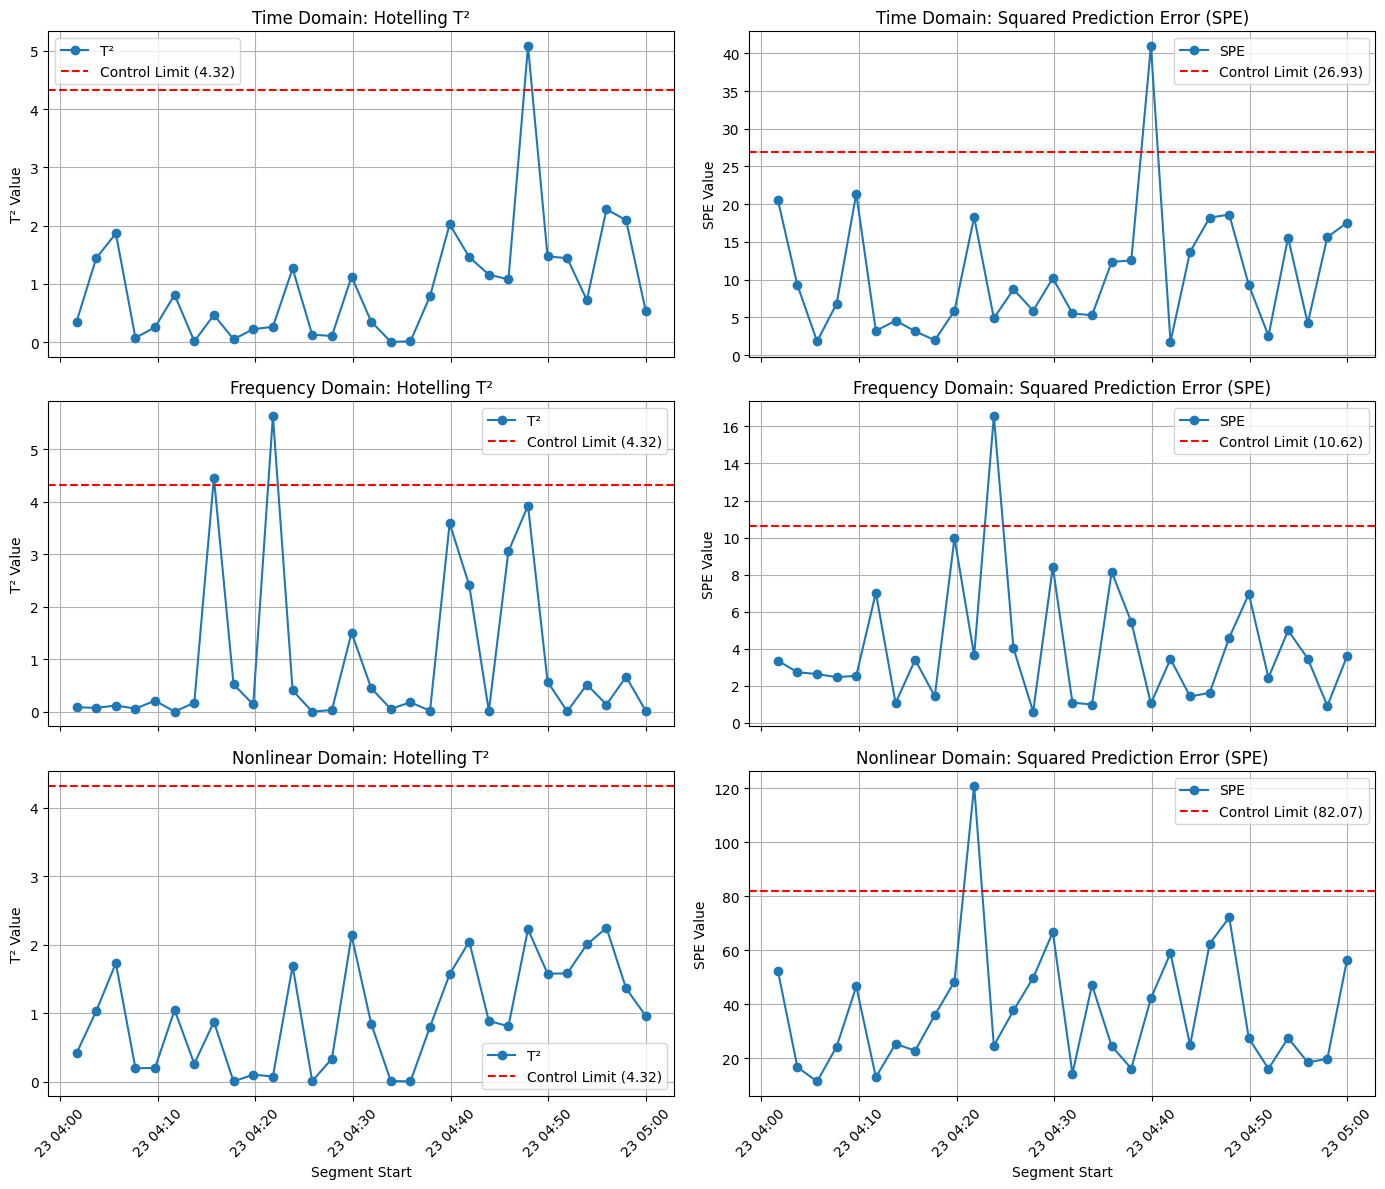

In [12]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import chi2, f
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# ---------------------------
# 데이터 불러오기, 전처리, HRV 분석
# ---------------------------

# 기존 Firebase 앱 초기화 (필요 시)
if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# Firebase 앱 초기화 (사용자의 키와 URL로 수정 필요)
cred = credentials.Certificate("hrv-data-a12d2-firebase-adminsdk-fbsvc-2e5c7d6e1f.json")
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

# gosleep.json 파일에서 데이터 불러오기 (firebase와 동일한 형식)
with open("wakeup.json", "r") as file_in:
    data_json = json.load(file_in)

# 데이터 정리 (오류 없는 데이터만 사용)
ppg_values = []
timestamps = []
for key, value in data_json["HeartRateData"].items():
    if not value["isError"]:
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성 및 타임스탬프 기준 정렬
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")

# 초반 2초 데이터 삭제 (시작 안정화)
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 청소 (샘플링 주파수 25Hz)
fs = 25
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# 피크 검출 함수
def find_prominent_peaks(signal, threshold=0.1, min_y=0):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > min_y:
            left_min = min(signal[max(0, i - 5):i])
            right_min = min(signal[i + 1:i + 6])
            prominence = signal[i] - max(left_min, right_min)
            if prominence > threshold:
                peaks.append(i)
    return peaks

# 전체 신호에 대해 피크 검출
peaks_indices = find_prominent_peaks(ppg_cleaned, threshold=0.1, min_y=0)
peaks_timestamps = df["Timestamp"].iloc[peaks_indices].values
peaks_values = ppg_cleaned[peaks_indices]

# 전체 신호 및 피크 시각화 (옵션)
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks_timestamps, peaks_values, color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 피크 기준으로 2분 단위 HRV 분석
hrv_results = []
i = 0
while i < len(peaks_timestamps):
    seg_start = peaks_timestamps[i]
    seg_end = seg_start + pd.Timedelta(minutes=2)
    segment_peaks = []
    while i < len(peaks_timestamps) and peaks_timestamps[i] < seg_end:
        segment_peaks.append(peaks_timestamps[i])
        i += 1
    if len(segment_peaks) < 2:
        print(f"Segment {seg_start} ~ {seg_end} has insufficient peaks, skipping HRV calculation.")
        continue
    
    # RR 간격 계산 (밀리초 단위)
    rr_intervals = np.diff(segment_peaks).astype("timedelta64[ms]").astype(int)
    
    # RR 간격을 피크 인덱스로 변환
    peaks_from_rr = nk.intervals_to_peaks(rr_intervals)
    
    # HRV 메트릭 계산
    hrv_time = nk.hrv_time(peaks_from_rr, sampling_rate=1000)
    hrv_freq = nk.hrv_frequency(peaks_from_rr, sampling_rate=1000)
    hrv_nonlinear = nk.hrv_nonlinear(peaks_from_rr, sampling_rate=1000)
    
    # 결과 저장
    result = {
        "Segment Start": seg_start,
        "Segment End": seg_end,
        "HRV Time Metrics": hrv_time,
        "HRV Frequency Metrics": hrv_freq,
        "HRV Nonlinear Metrics": hrv_nonlinear
    }
    hrv_results.append(result)

# HRV 결과를 하나의 DataFrame으로 결합
results_list = []
for res in hrv_results:
    row = {}
    row["Segment Start"] = res["Segment Start"]
    row["Segment End"] = res["Segment End"]
    time_dict = res["HRV Time Metrics"].iloc[0].to_dict()
    for key, val in time_dict.items():
        row["Time_" + key] = val
    freq_dict = res["HRV Frequency Metrics"].iloc[0].to_dict()
    for key, val in freq_dict.items():
        row["Freq_" + key] = val
    nonlinear_dict = res["HRV Nonlinear Metrics"].iloc[0].to_dict()
    for key, val in nonlinear_dict.items():
        row["Nonlinear_" + key] = val
    results_list.append(row)

df_hrv_results = pd.DataFrame(results_list)

# HRV 결과 CSV 파일로 저장 (옵션)
# df_hrv_results.to_csv("hrv_results.csv", index=False)
# print("HRV 결과가 hrv_results.csv 파일에 저장되었습니다.")

# ---------------------------
# Anomaly Detection using PCA (단일 주성분 사용)
# ---------------------------

def hotelling_limit_control(n_samples, R, alpha):
    # 단일 주성분(R=1)일 때 Hotelling T² 제어 한계
    ulc_t2 = (n_samples + 1) / n_samples * f.ppf(1 - alpha, 1, n_samples - 1)
    return ulc_t2

def q_statistic(X, loadings, scores):
    # SPE 계산: X_hat = scores * loadings.T, SPE = sum((X - X_hat)^2)
    X_hat = np.dot(scores, loadings.T)
    residual = X - X_hat
    SPE = np.sum(residual**2, axis=1)
    return SPE

def q_limit_control(SPE, alpha):
    mean_spe = np.mean(SPE)
    var_spe = np.var(SPE)
    d1 = var_spe / (2 * mean_spe)
    df_val = (2 * mean_spe**2) / var_spe
    ulc_spe = d1 * chi2.ppf(1 - alpha, df_val)
    return ulc_spe

alpha = 0.05  # 유의수준
domains = {"Time": "Time_", "Frequency": "Freq_", "Nonlinear": "Nonlinear_"}
anomaly_results = {}

for domain, prefix in domains.items():
    domain_cols = df_hrv_results.filter(regex=f"^{prefix}").columns
    if len(domain_cols) == 0:
        print(f"{domain} 도메인 컬럼을 찾을 수 없습니다.")
        continue

    # 데이터 매트릭스 X: (n_samples x m_features)
    X = df_hrv_results[domain_cols].values.astype(float)

    # 결측치 처리 (평균값으로 대체)
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)

    # 표준화 (z-score)
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_stdized = (X - X_mean) / X_std

    n_samples, m = X_stdized.shape
    if n_samples <= 1:
        print(f"{domain} 도메인: 샘플 수가 부족하여 PCA를 수행할 수 없습니다.")
        continue

    # 단일 주성분 사용
    n_components = 1
    pca = PCA(n_components=n_components)
    scores = pca.fit_transform(X_stdized)  # shape: (n_samples, 1)
    loadings = pca.components_.T           # shape: (m, 1)
    eigenvalues = pca.explained_variance_  # shape: (1,)
    R = n_components  # 1

    # Hotelling T² 계산: T²_i = (t_i1² / λ_1)
    T2 = (scores[:, 0]**2) / eigenvalues[0]
    ulc_t2 = hotelling_limit_control(n_samples, R, alpha)
    
    # SPE 계산
    SPE = q_statistic(X_stdized, loadings[:, :R], scores[:, :R])
    ulc_spe = q_limit_control(SPE, alpha)
    
    anomaly_results[domain] = {
        "T2": T2,
        "ulc_t2": ulc_t2,
        "SPE": SPE,
        "ulc_spe": ulc_spe,
        "segments": df_hrv_results["Segment Start"]
    }
    
# 그래프로 시각화
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

for i, (domain, results) in enumerate(anomaly_results.items()):
    row = i  # 0, 1, 2 (세로)

    # Hotelling T² 그래프
    axs[row, 0].plot(results["segments"], results["T2"], marker="o", linestyle="-", label="T²")
    axs[row, 0].axhline(results["ulc_t2"], color="red", linestyle="--", label=f"Control Limit ({results['ulc_t2']:.2f})")
    axs[row, 0].set_title(f"{domain} Domain: Hotelling T²")
    axs[row, 0].set_ylabel("T² Value")
    axs[row, 0].legend()
    axs[row, 0].grid()

    # SPE 그래프
    axs[row, 1].plot(results["segments"], results["SPE"], marker="o", linestyle="-", label="SPE")
    axs[row, 1].axhline(results["ulc_spe"], color="red", linestyle="--", label=f"Control Limit ({results['ulc_spe']:.2f})")
    axs[row, 1].set_title(f"{domain} Domain: Squared Prediction Error (SPE)")
    axs[row, 1].set_ylabel("SPE Value")
    axs[row, 1].legend()
    axs[row, 1].grid()

# x축 라벨 설정
for ax in axs[-1, :]:  # 마지막 행의 두 그래프
    ax.set_xlabel("Segment Start")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


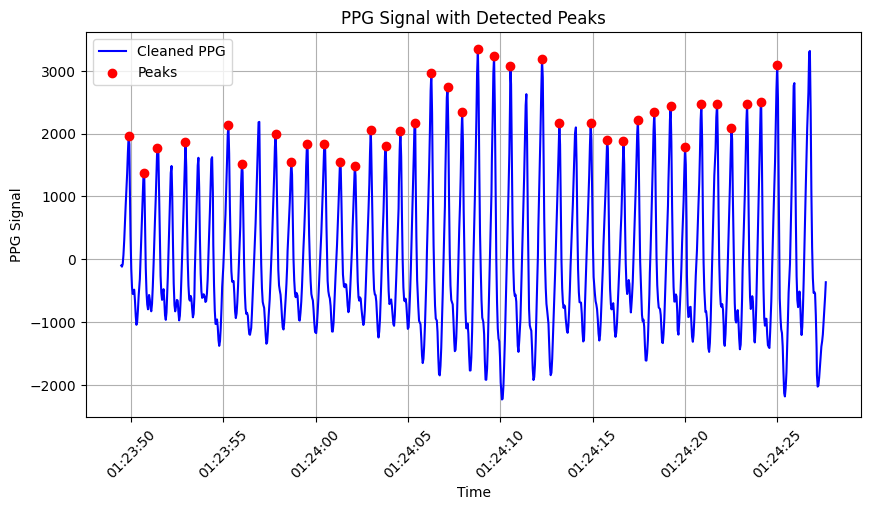

In [35]:
# neourokit2를 사용해 peak를 구하는 함수 peak는 정확하지만 탐지하지 못하는 peak가 있음
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# 🔹 Firebase 앱 새로 초기화
cred = credentials.Certificate("hrvdataset-firebase-adminsdk-oof96-2a96d6ac7f.json")  # Firebase Admin SDK JSON 파일
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

ref = db.reference("HeartRateData")
data = ref.get()

# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data.items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")  # 시간 순 정렬

# 초반 2초의 데이터를 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 처리 (25Hz 가정)
fs = 25  # 샘플링 주파수
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# PPG 피크 검출
peaks, info = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs)

# peaks 데이터프레임의 인덱스를 df와 일치시키기
peaks["Timestamp"] = df["Timestamp"].reset_index(drop=True)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks["Timestamp"][peaks["PPG_Peaks"] == 1], ppg_cleaned[peaks["PPG_Peaks"] == 1], color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()
